# Implementation of a Simple Multi-Layer Perceptron (MLP)

## Introduction

This project demonstrates the implementation of a basic Multi-Layer Perceptron **(MLP)** neural network from scratch using Python. We will build the essential components of a neural network, including **tensors**, operations like addition and multiplication, a **simple optimizer**, and an **automatic differentiation mechanism** to enable **backpropagation**. We will then use this MLP model to classify data generated by `make_blobs` from the `sklearn.datasets` library.

The project is divided into several stages:

1. **Defining Tensors**: Building the foundational data structure to store values and gradients.

2. **Operations on Tensors**: Implementing basic operations like addition, multiplication, and activation functions with automatic differentiation.

3. **Building the MLP Architecture**: Creating neurons, layers, and the overall MLP model.

4. **Training the Model**: Implementing the training loop with forward and backward passes.

5. **Evaluating the Model**: Visualizing the loss over epochs and testing the MLP on a synthetic dataset.

## Importing Necessary Libraries

In [185]:
# Import necessary libraries
from graphviz import Digraph
import random
import math
from math import exp
import matplotlib.pyplot as plt
import sys
from sklearn.datasets import make_blobs

This cell imports all the necessary libraries required for the project. `graphviz` is used for visualizing the computational graph, while `math` and `random` provide basic mathematical operations. `matplotlib` is used for plotting, and `make_blobs` is used for generating synthetic data.

In [186]:
# Increase recursion limit to handle large graphs
sys.setrecursionlimit(2000)

## Defining Helper Functions for Graph Visualization

In [187]:
from graphviz import Digraph

# Function to trace the computational graph from the root node
def trace(root):
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

# Function to draw the computational graph using Graphviz
def draw_dot(root, format='svg', rankdir='LR'):
  """
  format: png | svg | ...
  rankdir: TB (top to bottom graph) | LR (left to right)
  """
  assert rankdir in ['LR', 'TB']
  nodes, edges = trace(root)
  dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

  for n in nodes:
    dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
    if n.operator:
      dot.node(name=str(id(n)) + n.operator, label=n.operator)
      dot.edge(str(id(n)) + n.operator, str(id(n)))

  for n1, n2 in edges:
     dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

  return dot

In this cell, we define two functions: `trace()` and `draw_dot()`. These functions help in **visualizing the computational graph**. The computational graph shows how tensors are connected through various operations.



## Implementing the Tensor Class

In [188]:
class Tensor:

  def __init__(self, value, label='', children=(), operator=None):
    self.value = value
    self.children = set(children)
    self.operator = operator
    self.grad = 0.0
    self._backward = lambda  : None
    self.label = label


  def __repr__(self) -> str:
    return f"Tensor(label = {self.label}, value = {self.value}, grad = {self.grad}, operator = {self.operator})"


  def __add__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value + other.value
    out = Tensor(out_value, children=(self, other), operator='+')

    def backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad

    out._backward = backward

    return out

  def __radd__(self, other):
    return self + other


  def __sub__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value - other.value
    out = Tensor(out_value, children=(self, other), operator='-')

    def backward():
      self.grad += 1 * out.grad
      other.grad += -1 * out.grad

    out._backward = backward

    return out


  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out_value = self.value * other.value
    out = Tensor(out_value, children= (self, other), operator='*')

    def backward():
      self.grad += other.value * out.grad
      other.grad += self.value * out.grad

    out._backward = backward

    return out

  def __rmul__(self, other):
    return self * other


  def __truediv__(self, other):

      other = other if isinstance(other, Tensor) else Tensor(other)

      out_value = self.value / other.value
      out = Tensor(out_value, children= (self, other), operator='/')

      def backward():
        self.grad += (1 / other.value) * out.grad
        other.grad += (-self.value / (other.value ** 2)) * out.grad

      out._backward = backward

      return out


  def __pow__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value ** other.value
    out = Tensor(out_value, children= (self, ), operator='**')

    def backward():
      self.grad += other.value * self.value ** (other.value - 1) * out.grad

    out._backward = backward

    return out


  def backward(self):
    topo_sort = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.children:
          build_topo(child)
        topo_sort.append(v)

    build_topo(self)
    self.grad = 1
    for node in reversed(topo_sort):
      node._backward()


  def zero_grad(self):
    self.grad = 0.0

This cell defines the `Tensor` class, which represents the fundamental building block of our **neural network**. Each tensor holds a value, gradient, and its connections (children) in the **computational graph**. The class also defines various operations such as addition, subtraction, multiplication, division, and power, each with their respective backward functions for gradient computation.

## Creating and Visualizing Simple Tensors

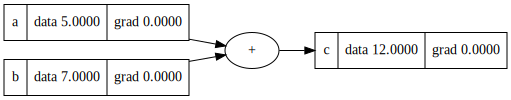

In [189]:
a = Tensor(5, label='a')
b = Tensor(7, label='b')

c = a + b
c.label = 'c'

# Draw and visualize the computational graph for c = a + b
draw_dot(c)

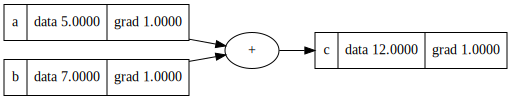

In [190]:
# Perform backward propagation to calculate gradients
c.backward()
draw_dot(c)

In this cell, we create two tensors, `a` and `b`, and perform an addition operation. We then visualize the computational graph of the resulting tensor `c`. The `backward()` function calculates the **gradients** of `a` and `b` with respect to `c`.

## Defining Activation Functions

In [191]:
class F:

  @staticmethod
  def tanh(x: Tensor) -> Tensor:

    input_value = x.value
    output_value = (exp(input_value) - exp(-input_value)) / (exp(input_value) + exp(-input_value))

    out = Tensor(output_value, children=(x, ), operator='tanh')

    def backward():
      x.grad += (1 - output_value ** 2) * out.grad

    out._backward = backward

    return out


  @staticmethod
  def sigmoid(x):
    input_value = x.value
    input_value = -1.0 * input_value
    output_value = 1.0 / (1.0 + exp(input_value))

    out = Tensor(output_value, children=(x, ), operator='sigm')

    def backward():
      x.grad += output_value * (1 - output_value) * out.grad

    out._backward = backward

    return out

This cell defines the **activation functions** `tanh` and `sigmoid`, which are commonly used in neural networks. Each function calculates the **forward pass** (output value) and the corresponding gradient for the backward pass.



## Defining Neurons, Layers, and the MLP Class

In [192]:
class Neuron:

  def __init__(self, input_size):

    self.weights = [Tensor(random.uniform(-1, 1)) for i in range(input_size)]
    self.bias = Tensor(random.uniform(-1, 1))

  def forward(self, x):
    res = sum([w_i * x_i for w_i, x_i in zip(self.weights, x)])
    return F.tanh(res + self.bias)

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return self.weights + [self.bias]

  def __print__(self):
    return self.parameters()

In [193]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    neuron_list = []
    for neuron in self.neurons:
      neuron_list.append(neuron.parameters())

    return neuron_list

  def __print__(self):
    return self.parameters()

In [194]:
class MLP:

  def __init__(self, input_size, layer_sizes):
    layers_total = [input_size] + layer_sizes
    self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    layer_list = []
    for layer in self.layers:
      layer_list.append(layer.parameters())

    return layer_list

  def __print__(self):
    return self.parameters()

This 3 cells defines the `Neuron`, `Layer`, and `MLP` classes. Each **neuron** holds a set of weights and a bias. A **layer** consists of multiple neurons, and an **MLP** consists of multiple layers. The MLP class is used to build the complete **neural network model**.

## Defining Loss Function

In [195]:
from typing import List

# Mean Squared Error (MSE) Loss Function

def criterion(y_hats: List[Tensor], Y) -> Tensor:
  return sum([(y_hat - y)**2 for y_hat, y in zip(y_hats, Y)]) / len(y_hats)

In this cell, we define the `criterion` function, which calculates the **Mean Squared Error** (MSE) **loss**.

## Defining Optimizer

In [196]:
# Simple SGD Optimizer

class Optimizer:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def zero_grad(self):
    for layer in self.parameters:
      for neuron in layer:
        for weight_and_bias in neuron:
          weight_and_bias.grad = 0

  def step(self):
    for layer in self.parameters:
      for neuron in layer:
        for weight_and_bias in neuron:
          weight_and_bias.value -= self.lr * weight_and_bias.grad

In this cell we define the `Optimizer` class, which implements a simple **Stochastic Gradient Descent** (SGD) optimizer to **update model** parameters based on **gradients**.

## Testing the Implementation with a Simple Dataset

In [197]:
# Simple dataset

X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y = [1.0, -1.0, -1.0, 1.0]

In [198]:
n_epochs = 10

# Number of features in the input layer
input_size = 3

# Number of neurons in each hidden and output layer
layer_sizes = [2, 1]

model = MLP(input_size, layer_sizes)

optim = Optimizer(model.parameters(), lr=0.3)

for i in range(n_epochs):
  # Forward pass: Compute predictions for the entire dataset
  y_hats = [model(x) for x in X]

  # Compute the loss
  loss = criterion(y_hats, y)

  # Zero the gradients to prevent accumulation from previous iterations
  optim.zero_grad()

  # Backward pass: Compute the gradient of the loss function with respect to model parameters
  loss.backward()

  # Update the model parameters using the optimizer
  optim.step()

  print(f'iteration: {i}, loss: {loss.value}')

iteration: 0, loss: 1.573914958230472
iteration: 1, loss: 1.223268792806636
iteration: 2, loss: 0.5389415126160055
iteration: 3, loss: 0.24599898963333577
iteration: 4, loss: 0.1377227264574249
iteration: 5, loss: 0.09486876254854759
iteration: 6, loss: 0.07206495539156269
iteration: 7, loss: 0.05773726875225496
iteration: 8, loss: 0.047955678168166656
iteration: 9, loss: 0.04088325878886649


This cell tests the **MLP model** on a **small dataset** with 4 samples. The training loop runs for 10 epochs, where in each epoch, the model makes predictions, calculates the loss, performs **backpropagation**, and updates the model parameters using the optimizer. The loss is printed after each epoch.



## Testing the MLP model with Synthetic Dataset

### Generating and Visualizing a Synthetic Dataset

In [199]:
# Generate synthetic dataset with 3 centers and visualize it

X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)

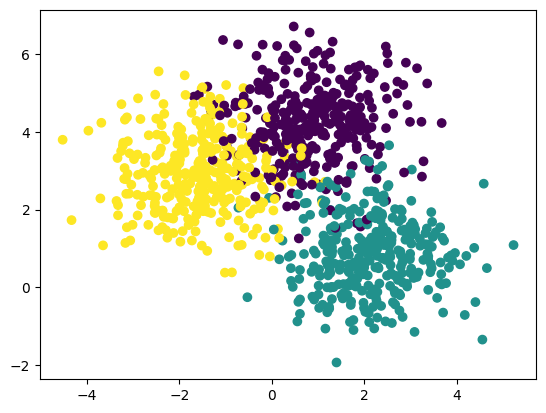

In [200]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In this cell, we generate a synthetic dataset using `make_blobs` with **1000 samples**, **3 centers** (classes), and **2 features**. The dataset is visualized using a **scatter plot**.

### Training the Model on the Synthetic Dataset

In [201]:
n_epochs = 100

# Number of features in the input layer
input_size = 2

# Number of neurons in each hidden and output layer
layer_sizes = [2, 5, 1]

model = MLP(input_size, layer_sizes)

optim = Optimizer(model.parameters(), lr=0.3)

losses = []

for i in range(1, n_epochs + 1):
  # Forward pass: Compute predictions for the entire dataset
  y_hats = [model(x) for x in X]

  # Compute the loss
  loss = criterion(y_hats, y)

  # Store the loss value
  losses.append(loss.value)

  # Zero the gradients to prevent accumulation from previous iterations
  optim.zero_grad()

  # Backward pass: Compute the gradient of the loss function with respect to model parameters
  loss.backward()

  # Update the model parameters using the optimizer
  optim.step()


print(f'iteration: {i}, loss: {loss.value}')

iteration: 100, loss: 0.5455366509593534


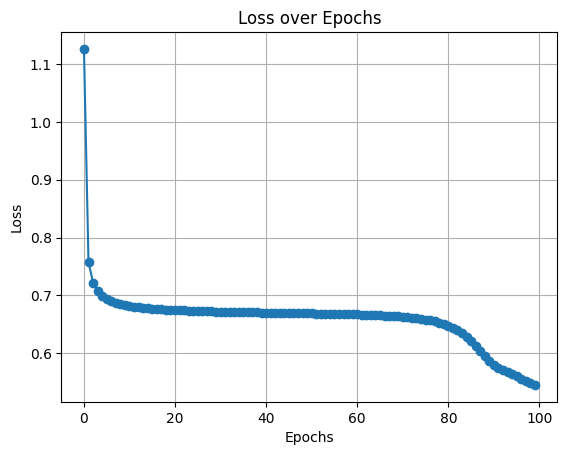

In [202]:
# Plot the loss values over the epochs

plt.plot(range(n_epochs), losses, marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

This final cell trains the **MLP model** on the synthetic dataset for 100 epochs. After each epoch, the loss is stored and plotted to visualize the loss progression over time. The loss is expected to decrease as the model learns to classify the data better.